In [1]:
''' Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

    Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review

Objective:

Plot a t-SNE data visualization for the customer reviews to classify +ve/-ve using BoW, TFIDF, Avg Word2Vector and TFIDF Word2Vector text processing methods.
'''
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# con is the object is used to communicate
con = sqlite3.connect('database.sqlite') 



#removing the reviews where score =3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


C:\Users\NoTitle\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
print(filtered_data.shape) #printing attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#Converting score values into positive(score>3) and negative(score<3)
def partition(x):
    if x < 3:
        return "Negative"
    return "Positive"

actualscore= filtered_data['Score']
PositiveNegative=actualscore.map(partition)
filtered_data['Score']=PositiveNegative

filtered_data.shape# shape of the table

(525814, 10)

In [4]:
filtered_data.head(5)#print top 5 data points

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
##Data cleaning process
#There are many duplicate reviews in the Dataset
#Beacause users are submitted reviews for 1 flavour product but system wrongly posted for other flavours of the same products.
#we can detect the duplicates by using  User ID, Profile name, Time & Review text
find_duplicates=filtered_data.groupby(['UserId','ProfileName','Time','Text'])
find_duplicates.size()

UserId              ProfileName                               Time        Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape# shape of the table after deduplication

(364173, 10)

In [8]:
#Due to the system error sometimes helpfulness numerator is more than denominator.
#So we delete this type of entries also.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator > HelpfulnessDenominator ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
display.shape

(2, 10)

In [10]:
# remove  2 above incorrected lines from the final data
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [12]:
#How many attributes and data points are present in the final data set
print(final.shape)
final['Score'].value_counts()

(364171, 10)


Positive    307061
Negative     57110
Name: Score, dtype: int64

In [13]:
# Text preprocessing using stop word removal, lemmatization,stemming
# We are cleaning Html tags, puncations, special set of characters
#converting all words into lowercase words
#Removing stopwords  from the reviews

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stpwd= set(stopwords.words('english'))#set of stopwords
snwbl= nltk.stem.SnowballStemmer('english')#initialising the snowball stemmer

def cleanHTML(sentence):#function to clean the word of any html-tags
    cleanc=re.compile('<.#?>')
    cleantxt=re.sub(cleanc,' ',sentence)
    return cleantxt

def cleanpunc(sentence):#function to clean the word of any punctuation or special characters.
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

print(stpwd)

{'the', 'while', 'shouldn', 'll', 'until', 'under', 'd', 'him', "you've", 'being', 'once', 'will', 've', "wouldn't", "hadn't", 'needn', 'off', 'against', "haven't", 'have', 'other', "that'll", 'again', 'if', 'such', "weren't", 'all', 't', 'because', 'doesn', 'where', 'he', 'below', 'as', 'who', 'am', 's', 'she', 'through', 'ourselves', 'hers', 'having', 'we', 'o', "won't", 'their', 'whom', "didn't", 'can', 'a', "hasn't", 'which', 'during', 'just', 'couldn', 'should', 'very', 'at', 'myself', 'about', 'for', 'your', 'of', "doesn't", 'these', "she's", 'they', 'ain', 'what', 'into', 'nor', 'down', "shan't", 'had', 'haven', 'between', 're', 'isn', 'wouldn', "you'll", 'mightn', 'are', 'be', 'her', 'some', 'do', 'hasn', 'shan', 'those', 'and', 'that', 'ma', 'not', 'were', 'weren', 'more', "wasn't", 'further', 'did', "shouldn't", 'wasn', 'when', 'me', 'each', 'himself', 'this', 'doing', 'over', 'won', "you'd", 'then', 'too', 'in', "should've", "don't", 'by', 'to', 'above', 'does', "couldn't", 

In [14]:
i=0
str1=' '
final_string=[]#storing final cleaned text corpus
all_pos_words=[]#storing all +ve words
all_neg_words=[]#storing all +ve words
s=''

for sent in final['Text'].values:
    filtered_sent=[]
    sent=cleanHTML(sent)#cleaning HTML tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stpwd):
                    s=(snwbl.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sent.append(s)
                    if (final['Score'].values)[i]== 'Positive':#list of all words describes +ve review
                        all_pos_words.append(s)
                    if (final['Score'].values)[i]== 'Negetive':#list of all words describes -ve reviews
                        all_neg_words.append(s)
                else:
                    continue
            else:
                continue
    strl=b" ".join(filtered_sent)
    final_string.append(strl)
    i+=1

In [15]:
#we add the cleaned text column to final data set
final['CleanText']=final_string
final['CleanText']=final['CleanText'].str.decode("utf-8")
#final['CleanText']
print(final.shape)


(364171, 11)


In [16]:
final.head(3)#top 3 rows of final data set

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [17]:
#creating a new database with the name of final
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [18]:
#conn is new object is used to communicate
conn = sqlite3.connect('final.sqlite')
finalDF=pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [19]:
print(finalDF.shape)#shape of final table

(364171, 12)


In [85]:
#taking sample from 364 k reviews
#Because of my system configuration is very less, I have taken 2000 +ve and 2000 -ve reviews and all +ve and -ve reviews text store into a variable cln_text.
#similarly labels are also stored in score_lbl

smpl_no=4000
pos=finalDF[['Score','CleanText']][finalDF['Score']=='Positive'].sample(n=int(smpl_no/2))
neg=finalDF[['Score','CleanText']][finalDF['Score']=='Negative'].sample(n=int(smpl_no/2))
cln_txt=pos['CleanText'].append(neg['CleanText'])
score_lbl=pos['Score'].append(neg['Score'])

In [86]:
#Bag of words 
#converts a text document into matrix of tokens called sparse matrix
count_vect = CountVectorizer()
BoWug_counts = count_vect.fit_transform(cln_txt.values)

print("the type of count vectorizer ",type(BoWug_counts))#type of the matrix
print("the shape of out text BOW vectorizer ",BoWug_counts.get_shape())#shape and unique words of sample data
print("the number of unique words ", BoWug_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 8877)
the number of unique words  8877


In [87]:
import warnings
warnings.filterwarnings('ignore')#ignoring warning errors
from sklearn.preprocessing import StandardScaler
data_4000=StandardScaler().fit_transform(BoWug_counts.toarray())# converting sparse matrix into dense matrix.

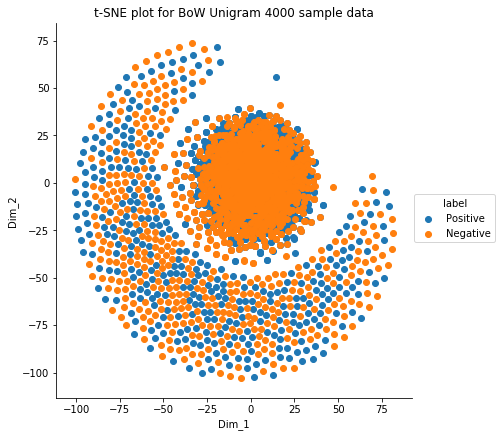

In [88]:
#plotting t-sne using Bow unigrams with dafault perplxity=30
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_4000)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for BoW Unigram 4000 sample data')#plotting title
plt.show()

In [96]:
#taking sample of data.
smpl_no=4000
pos=finalDF[['Score','CleanText']][finalDF['Score']=='Positive'].sample(n=int(smpl_no/2))
neg=finalDF[['Score','CleanText']][finalDF['Score']=='Negative'].sample(n=int(smpl_no/2))
cln_txt=pos['CleanText'].append(neg['CleanText'])
score_lbl=pos['Score'].append(neg['Score'])

In [97]:
#counting bigrams and unigrams
count_vect = CountVectorizer(ngram_range=(1,2))#converts collection of text documents into a sparse matrix
BoWbg_counts = count_vect.fit_transform(cln_txt.values)#returning term document matrix

print("the type of count vectorizer ",type(BoWbg_counts))
print("the shape of out text BOW vectorizer ",BoWbg_counts.get_shape())
print("the number of unique words including both unigrams and bigrams", BoWbg_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 116614)
the number of unique words including both unigrams and bigrams 116614


In [98]:
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[15000:15110])

some sample features(unique words in the corpus) ['canada', 'canada anyway', 'canada drys', 'canada europ', 'canada experi', 'canada nestl', 'canadian', 'canadian bacon', 'canadian cooki', 'canberri', 'canberri appl', 'cancel', 'cancel dont', 'cancel futur', 'cancel membership', 'cancel messag', 'cancel month', 'cancel next', 'cancel order', 'cancel second', 'cancel soon', 'cancel stand', 'cancel starter', 'cancel subscrib', 'cancel subscript', 'cancel time', 'cancel without', 'cancel write', 'cancer', 'cancer bodi', 'cancer cannot', 'cancer caus', 'cancer cell', 'cancer dont', 'cancer free', 'cancer kidney', 'cancer one', 'cancer present', 'cancer prostat', 'cancer stuck', 'cancer told', 'cancer want', 'candi', 'candi although', 'candi amazon', 'candi around', 'candi arriv', 'candi ate', 'candi bad', 'candi bar', 'candi beadsin', 'candi bite', 'candi box', 'candi breakfast', 'candi busi', 'candi call', 'candi calori', 'candi canist', 'candi caution', 'candi central', 'candi chocol', '

In [99]:
# First I have taken 10000 points I got memory error because my system has less configurable.
#So that is the reason I have taken 4K points only
tsvd_bg = TruncatedSVD(n_components=4000)#No of components means total dimensions
tsvd_bg_vec = tsvd_uni.fit_transform(BoWbg_counts)
type(tsvd_bg_vec)

numpy.ndarray

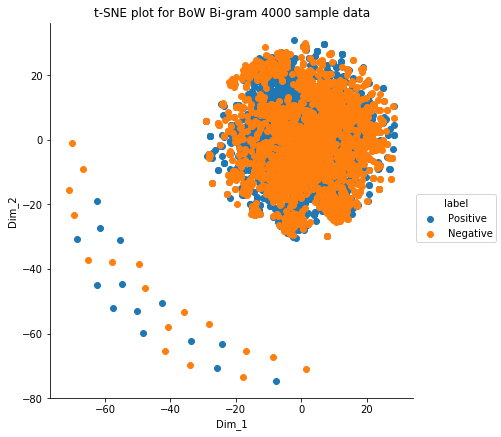

In [100]:
#plotting t-sne using BOW bigrams and scores with default perplexity=30
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tsvd_bg_vec)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for BoW Bi-gram 4000 sample data')
plt.show()
#The plot points are not clearly separable.

In [101]:
#taking sample 4000 points for TFIDF
smpl_no=4000
pos=finalDF[['Score','CleanText']][finalDF['Score']=='Positive'].sample(n=int(smpl_no/2))
neg=finalDF[['Score','CleanText']][finalDF['Score']=='Negative'].sample(n=int(smpl_no/2))
cln_txt=pos['CleanText'].append(neg['CleanText'])
score_lbl=pos['Score'].append(neg['Score'])

In [102]:
tfidf_vect = TfidfVectorizer()#convert the reviews into a matrix of TF-IDF 
tfidf_Ug = tfidf_vect.fit_transform(cln_txt.values)#returning sparse matrix

print("the type of count vectorizer ",type(tfidf_Ug))
print("the shape of out text TF-IDF vectorizer ",tfidf_Ug.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Ug.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TF-IDF vectorizer  (4000, 8850)
the number of unique words including both unigrams and bigrams  8850


In [103]:
features = tfidf_vect.get_feature_names()# array mapping from feature integer indices to feature name.
print("some sample features(unique words in the corpus)",features[1200:1400])

some sample features(unique words in the corpus) ['casey', 'cash', 'cashew', 'cashier', 'casper', 'casserol', 'cast', 'castagn', 'castaway', 'castor', 'casual', 'cat', 'catalogu', 'cataract', 'catastroph', 'catch', 'categori', 'catfish', 'catfood', 'catnip', 'catsur', 'cattl', 'caught', 'cauldron', 'cauliflow', 'caus', 'caution', 'cautionari', 'cautious', 'cavali', 'cave', 'caveat', 'caviar', 'caviti', 'cayenn', 'cbtl', 'cdm', 'ceareal', 'ceas', 'ceaser', 'cecco', 'ceil', 'celebr', 'celeri', 'celest', 'celesti', 'celiac', 'cell', 'cella', 'cellophan', 'cellular', 'celsius', 'celtic', 'cement', 'cent', 'center', 'centerpiec', 'cento', 'centr', 'central', 'centuri', 'ceo', 'ceram', 'ceramicwar', 'cereal', 'cerelac', 'ceremoni', 'cerial', 'certain', 'certif', 'certifi', 'certin', 'cet', 'ceylon', 'cha', 'chaff', 'chagrin', 'chai', 'chain', 'chair', 'chalk', 'chalki', 'challah', 'challeng', 'chamomil', 'chamoy', 'champagn', 'champion', 'champlain', 'chanc', 'chang', 'channa', 'chantea', 'c

In [104]:
#Converting sparse matrix into dense matrix
from sklearn.preprocessing import StandardScaler
data_4000=StandardScaler().fit_transform(tfidf_Ug.toarray())

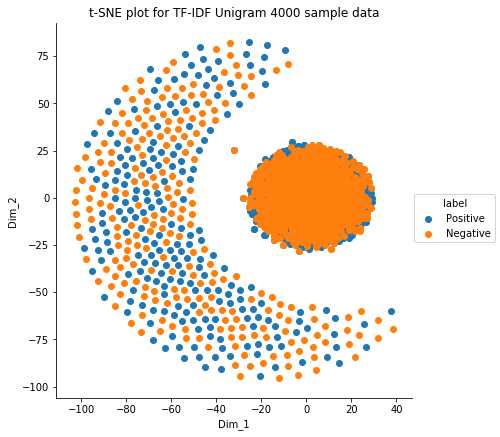

In [105]:
#T-SNE plot for TFIDF with unigrams
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_4000)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for TF-IDF Unigram 4000 sample data')
plt.show()

In [106]:
#taking sample data
smpl_no=4000
pos=finalDF[['Score','CleanText']][finalDF['Score']=='Positive'].sample(n=int(smpl_no/2))
neg=finalDF[['Score','CleanText']][finalDF['Score']=='Negative'].sample(n=int(smpl_no/2))
cln_txt=pos['CleanText'].append(neg['CleanText'])#all cleantext stored here
score_lbl=pos['Score'].append(neg['Score'])#score labels are stored here.

In [107]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidfBg = tfidf_vect.fit_transform(cln_txt.values)

print("the type of count vectorizer ",type(tfidfBg))
print("the shape of out text TF-IDF vectorizer ",tfidfBg.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfBg.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TF-IDF vectorizer  (4000, 116207)
the number of unique words including both unigrams and bigrams  116207


In [108]:
features = tfidf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[17900:18110])

some sample features(unique words in the corpus) ['chicken real', 'chicken recip', 'chicken rice', 'chicken salad', 'chicken sauc', 'chicken serv', 'chicken show', 'chicken shrimp', 'chicken skin', 'chicken small', 'chicken soup', 'chicken stick', 'chicken strip', 'chicken subpar', 'chicken sweet', 'chicken tablespoon', 'chicken tast', 'chicken tasti', 'chicken tender', 'chicken tini', 'chicken tofu', 'chicken treat', 'chicken tri', 'chicken turkey', 'chicken tuscani', 'chicken use', 'chicken veget', 'chicken veggi', 'chicken white', 'chicken wing', 'chicken wrap', 'chicken year', 'chickori', 'chiclet', 'chiclet blister', 'chicori', 'chicori fiber', 'chicori formul', 'chicori ginger', 'chicori love', 'chicori root', 'chicori someth', 'chihuahua', 'chihuahua eat', 'chihuahua favorit', 'chihuahua ive', 'child', 'child anaphylact', 'child bite', 'child breastfe', 'child car', 'child could', 'child done', 'child enjoy', 'child gross', 'child grow', 'child knew', 'child need', 'child normal

In [109]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(tfidfBg[1,:].toarray()[0],features,5)

In [110]:
top_tfidf

,feature,tfidf
0,gaggia,0.235338
1,starbuck,0.156945
2,coffe,0.139246
3,bean,0.136424
4,bitter,0.127784


In [111]:
tsvd_tfidf_bg = TruncatedSVD(n_components=4000)#No of components means total dimensions
tsvd_tfidf_bg_vec = tsvd_uni.fit_transform(BoWbg_counts)#converting sparse matrix into numpy array
type(tsvd_tfidf_bg_vec)

numpy.ndarray

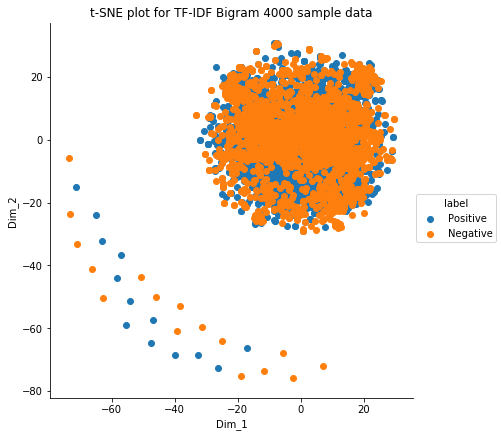

In [113]:
#t-sne plot for TFIDF bigram with default perplexity=30
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tsvd_tfidf_bg_vec)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for TF-IDF Bigram 4000 sample data')
plt.show()

In [114]:
#taking sample of data
smpl_no=4000
pos=finalDF[['Score','CleanText']][finalDF['Score']=='Positive'].sample(n=int(smpl_no/2))
neg=finalDF[['Score','CleanText']][finalDF['Score']=='Negative'].sample(n=int(smpl_no/2))
cln_txt=pos['CleanText'].append(neg['CleanText'])
score_lbl=pos['Score'].append(neg['Score'])
cln_txt.head(5)

170234    fresh delici second case back done make awesom...
356139    delici soft almost fall apart soft great cinna...
66494     log place maca order time order two bag maca r...
235995    particular feed pound maltes general dont give...
187597    cocoa almond right make healthi snack dessert ...
Name: CleanText, dtype: object

In [115]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in cln_txt.values:
    list_of_sent.append(sent.split())
#list_of_sent[0:4000]
#list_of_sent[0]

In [116]:
print(final['CleanText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['fresh', 'delici', 'second', 'case', 'back', 'done', 'make', 'awesom', 'hummus', 'also', 'delici', 'replac', 'peanut', 'butter', 'cant', 'high', 'sugar', 'stuff']


In [117]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [118]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))#finding 5 ties occured words
print("sample words ", w2v_words[0:100])

number of words that occured minimum 5 times  2910
sample words  ['fresh', 'delici', 'second', 'case', 'back', 'done', 'make', 'awesom', 'hummus', 'also', 'replac', 'peanut', 'butter', 'cant', 'high', 'sugar', 'stuff', 'soft', 'almost', 'fall', 'apart', 'great', 'cinnamon', 'flavor', 'allow', 'eat', 'half', 'time', 'could', 'place', 'maca', 'order', 'two', 'bag', 'remark', 'product', 'check', 'find', 'price', 'organ', 'raw', 'tri', 'frank', 'feel', 'urg', 'quit', 'pleas', 'lot', 'review', 'tast', 'actual', 'like', 'smoothi', 'mix', 'hot', 'quinoa', 'cereal', 'must', 'food', 'wife', 'seem', 'person', 'matter', 'think', 'roast', 'malt', 'nutti', 'earthi', 'impact', 'health', 'increas', 'posit', 'overal', 'physic', 'mani', 'herb', 'supplement', 'healthi', 'year', 'unlik', 'anyth', 'els', 'may', 'bodi', 'particular', 'well', 'obvious', 'other', 'dont', 'experi', 'worth', 'trial', 'feed', 'pound', 'maltes', 'general', 'give', 'commerci', 'made', 'treat']


In [119]:
w2v_model.wv.most_similar('like')

[('flavor', 0.9949482679367065),
 ('sweet', 0.9944512844085693),
 ('tast', 0.9885748624801636),
 ('drink', 0.9871721267700195),
 ('milk', 0.9866968393325806),
 ('realli', 0.983709990978241),
 ('water', 0.9824742674827576),
 ('chocol', 0.9818731546401978),
 ('strong', 0.9814743399620056),
 ('add', 0.9806797504425049)]

In [120]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
type(sent_vectors)

4000
50


list

In [121]:
sent_vectors[1]

array([ 4.31948902e-01, -2.61753231e-01, -2.07923807e-01,  3.73410597e-01,
        2.48507056e-01, -1.89843028e-01,  2.39951329e-01, -9.20964154e-01,
       -2.96847797e-01, -3.72913106e-01,  1.29668695e-01,  8.72974196e-02,
        3.51090123e-01,  1.21599253e-01,  9.44580570e-05,  2.58953141e-01,
        2.19299456e-01,  4.91972244e-01,  4.96602445e-01, -3.53216941e-01,
       -1.74546453e-01, -7.40219561e-01,  6.66950454e-01,  1.40419341e-01,
        2.29103690e-01, -3.22197660e-01,  3.26408078e-01, -2.61475842e-01,
       -1.00939659e-01,  7.17431098e-02, -2.03426873e-01, -4.97065497e-01,
        2.17939534e-01,  3.58712917e-01,  4.85617343e-01,  1.58456913e-01,
        3.60412262e-01,  2.36713955e-01, -3.61388841e-01, -1.07371508e+00,
        2.66705565e-01, -6.94869318e-01, -1.52994070e-01, -4.40124041e-01,
        2.11419099e-01, -3.64461162e-01, -1.05945088e-02, -1.21425620e-01,
       -1.09134574e-01, -2.04352405e-01])

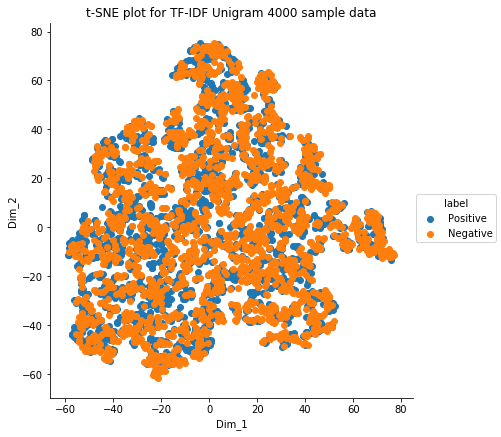

In [122]:
#TSNE plot for avg w2vec with default perplexity=30
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for TF-IDF Unigram 4000 sample data')
plt.show()

#TFIDF W2VEC  is another process to convert sentences into vectors
#Take weighted sum of the vectors divided by the sum of all the tfidfs

In [123]:
#taking sample of data
smpl_no=4000
pos=finalDF[['Score','CleanText']][finalDF['Score']=='Positive'].sample(n=int(smpl_no/2))
neg=finalDF[['Score','CleanText']][finalDF['Score']=='Negative'].sample(n=int(smpl_no/2))
cln_txt=pos['CleanText'].append(neg['CleanText'])
score_lbl=pos['Score'].append(neg['Score'])
cln_txt.head(5)

172047    delici nutriti altern youll find vend machin t...
175640    thing awesom kind thing bitter dark chocol per...
39044     love product take work breakfast also help man...
88635     chip good whole famili love littl disappoint d...
326833    big retriev lab mix thorough enjoy treat didnt...
Name: CleanText, dtype: object

In [124]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_vectors: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = tfidfBg[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [125]:
type(tfidf_sent_vectors)

list

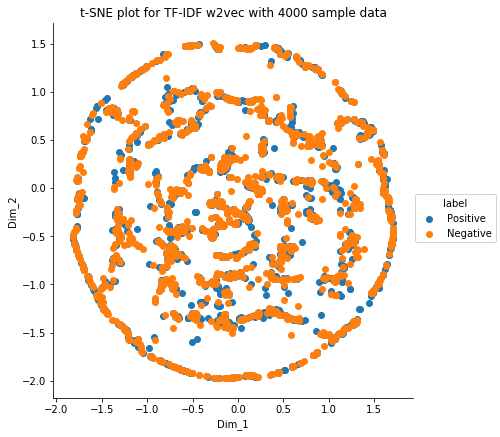

In [126]:
#TSNE plot for TF-IDF weighted Word2Vec with default perplexity=30
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for TF-IDF w2vec with 4000 sample data')
plt.show()

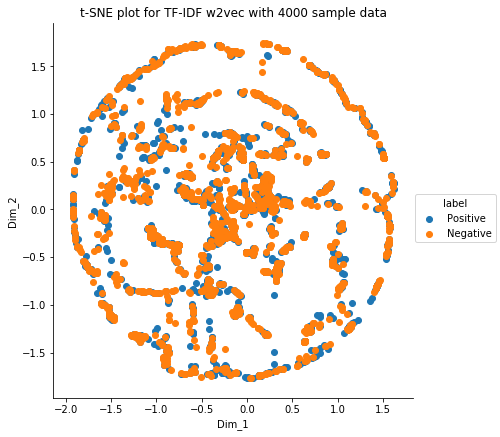

In [127]:
#TSNE plot for TF-IDF weighted Word2Vec with perplexity=40
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=40)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_lbl)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1','Dim_2','label'))
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot for TF-IDF w2vec with 4000 sample data')
plt.show()